In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model, IdentityModel, GPT
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS, ExampleDataset
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad1d, EmbedLookup, Reshape

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import numpy as np


In [ ]:
#Cosmosis blank parameters

lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_param = {'train_param': {'input_dict': {'X': ['feature_1','feature_2'],
                                           'feature_3': ['feature_3']},
                            'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                           'feature_2': [Reshape(-1), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()]},
                            'boom': 'bang'}}

model_param = {'some_param': 128,
               'X': None,
               'y': 'y',
               'embed_param': {'feature_3': (voc,vec,padding_idx,trainable),
                               'some_param': True,
                               'flatten': True}} 
                                       
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([DS], 
              Model,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Optimizer, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=LossFunction,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=12, epochs=1, gpu=True)


In [2]:
#example cosmosis dataset (CDataset)

class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)


class ExampleDataset(CDataset):
    #zero is the lookup for the padding index 
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0},
                    'feature_6': {'e': 1, 'f': 2, 'g': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1]),
                       'feature_6': np.asarray(['e','f','g'])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2]),
                       'feature_6': np.asarray(['f','f','g'])}}
        
        print(boom)
        return datadic
    
lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_param = {'train_param': {'input_dict': {
                                           'X2': ['feature_1','feature_2'], 
                                           'X3': ['feature_2'],
                                           'embed_3': ['feature_3'],
                                           'embed_4': ['feature_4'],
                                           'target': ['feature_5'],
                                            },
                            'transforms': {'feature_1': [ExampleTransform(10), Reshape((-1)), AsTensor()],
                                           'feature_2': [Reshape((-1)), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()],
                                           'feature_4': [Pad1d(5), EmbedLookup(lookup_feature_4), AsTensor()],
                                           'feature_5': [AsTensor()],
                                           'feature_6': [Pad1d(5), EmbedLookup(lookup_feature_6), AsTensor()]},
                            'boom': 'bang'}}
    
ed = ExampleDataset(**ds_param['train_param'])
print('ed[1]: ', ed[1])

model_param = {'device': 'cpu',
               'X': ['X2', 'X3'],
               'y': 'target',
               'embed_param': {'embed_3': (4,8,0,False),
                               'embed_4': (5,8,0,False),
                               'flatten': True}
              }

im = IdentityModel(model_param)
print(im)
print('embedding_layer: ', im.embedding_layer)

out = im(ed[1])
print('out: ', out)
print('out.shape: ', out.shape) # (1+4+4+5*8+5*8) = 89


bang
CDataset created...
ed[1]:  {'X2': tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500], dtype=torch.float64), 'X3': tensor([0.0200, 0.0300, 0.0400, 0.0500], dtype=torch.float64), 'embed_3': tensor([1, 0, 0, 0, 0]), 'embed_4': tensor([3, 3, 4, 0, 0]), 'target': tensor([1.1000], dtype=torch.float64)}
CModel loaded...
IdentityModel(
  (layers): ModuleList(
    (0): Identity()
  )
)
embedding_layer:  {'embed_3': Embedding(4, 8, padding_idx=0), 'embed_4': Embedding(5, 8, padding_idx=0)}
out:  tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500,  0.0200,  0.0300,  0.0400,
         0.0500, -1.8080,  0.6285, -1.3383,  0.0998, -0.8398,  0.7543, -0.2520,
        -1.5587,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.6

In [4]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
                            
ds_param = {'train_param': {'input_dict': {'model_input': ['X'],
                                           'y': ['y']},
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples': 100,
                                         'n_features': 5},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32'}}

sk = SKDS(**ds_param['train_param'])

sk[1]


creating scikit learn make_regression dataset...
CDataset created...


{'model_input': array([-0.3608357 , -0.9982134 , -1.9043049 ,  0.8560514 , -0.05913163],
       dtype=float32),
 'y': array([-189.71077], dtype=float32)}

In [5]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [AsTensor()],
                                           'X': [AsTensor()]},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 1000,
                                         'n_features': 30,
                                         'n_informative': 20,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}

sk = SKDS(**ds_param['train_param'])

print(sk[1])


creating scikit learn make_classification dataset...
CDataset created...
{'X': tensor([ 2.2014,  0.2377, -1.4595,  1.0150, -1.6540, -1.7680, -2.1540,  0.0710,
        -0.9041, -1.8005,  0.5380,  0.5787, -0.0746,  1.5057,  1.2983, -0.0611,
        -2.2052, -0.9135, -1.6897,  0.3303,  2.2553,  2.1814,  1.5496,  6.5788,
         2.0297,  3.7339, -1.3919, -1.3693, -0.5834,  2.6215]), 'y': tensor([3])}


In [ ]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_param = {'train_param': {'input_dict': {'features': ['images'],
                                           'y': ['labels']},
                            'dataset': 'MNIST',
                            'tv_param': {'root': './data/',
                                         'train': True,
                                         'download': True,
                                         'transform': transforms.Compose([transforms.Resize(224)]),
                                         'target_transform': None}}}

tvds = TVDS(**ds_param['train_param'])
tvds[1]


In [ ]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_param={'dataset': 'MNIST',
          'tv_param': {'root': './data/',
                       'train': True,
                       'download': True,
                       'transform': transforms.Compose([transforms.Resize(224)]),
                       'target_transform': None}}

tvds = TVDS(**ds_param)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
CModel loaded...
running model on gpu...

.....................

total elapsed time: 0:00:10.379940
epoch: 20
y_pred:  tensor([-1007.6146], device='cuda:0')
y:  tensor([-978.5800], device='cuda:0')
train loss: 13268.731758887614, val loss: 14742.860712466032
lr: 0.005
early stopping!  learning rate is below the set minimum...

........final........

total learning time: 0:00:18.134073
test loss: 12451.756708559782


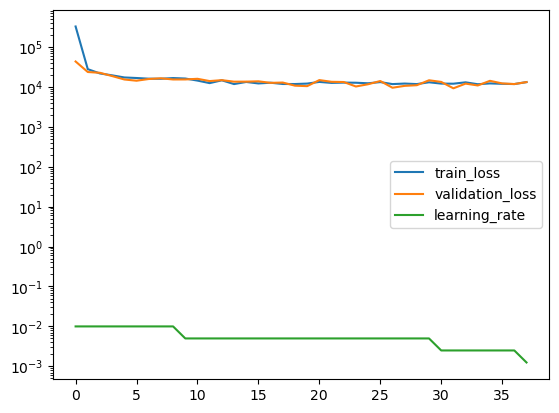

In [2]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet) 

model_param = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32',
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples':20000,
                                         'n_features': 256,
                                         'n_informative': 200}}}
             
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .00125} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 3,
               'cooldown': 3}

learn = Learn([SKDS], 
              FFNet,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=MSELoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=128, epochs=50, gpu=True)


creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
CModel loaded...
running model on gpu...

.....................

total elapsed time: 0:00:11.132017
epoch: 3
y_pred:  tensor([ 0.0817,  0.2036, -1.3618,  0.8275], device='cuda:0')
y:  tensor(1, device='cuda:0')
train loss: 0.007786641014234978, val loss: 0.007030465397346987
lr: 0.01
accuracy_score train score: 0.585064674908425, validation score: 0.6446981837606838

.....................

total elapsed time: 0:00:22.407600
epoch: 7
y_pred:  tensor([ 0.6988, -0.1470,  2.5835, -1.1546], device='cuda:0')
y:  tensor(2, device='cuda:0')
train loss: 0.004288670617571926, val loss: 0.0049808404257154874
lr: 0.01
accuracy_score train score: 0.8103250915750916, validation score: 0.7773103632478633

.....................

total elapsed time: 0:00:33.567806
epoch: 11
y_pred:  tensor([-2.6078,  0.0113,  0.4740, -0.9827], device='cuda:0')
y:  tensor(1, device='cuda:0')
train los

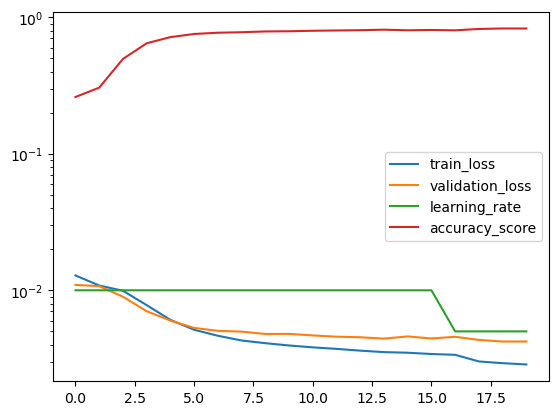

In [3]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4,
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [SqueezeN()],
                                           'X': []},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 100000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_redundant': 5,
                                         'n_repeated': 5,
                                         'n_clusters_per_class': 5,
                                         'flip_y': 0.05,
                                         'class_sep': 0.05,
                                         'n_classes': 4}}}
                                     
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'metric_name': 'accuracy_score', #sklearn
                 'metric_param': {}}

opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 1}

learm = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, 
              sample_param=sample_param, opt_param=opt_param, 
              sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param,
              adapt=(300,256,.2), batch_size=128, epochs=20, 
              save_model='demo_model')


creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
CModel loaded...
running model on gpu...

.....................

total elapsed time: 0:00:11.269120
epoch: 3
y_pred:  tensor([6.2525, 0.1186, 2.2089, 0.0677], device='cuda:0')
y:  tensor(0, device='cuda:0')
train loss: 0.008362283238513402, val loss: 0.0074876770735360105
lr: 0.01
multiclass_accuracy train score: 0.5405362844467163, validation score: 0.6073050498962402

.....................

total elapsed time: 0:00:22.552177
epoch: 7
y_pred:  tensor([ 1.1422, -2.6657, -0.0634, -1.3452], device='cuda:0')
y:  tensor(0, device='cuda:0')
train loss: 0.004481198362948121, val loss: 0.004935308238173015
lr: 0.01
multiclass_accuracy train score: 0.8009243607521057, validation score: 0.7769097685813904

.....................

total elapsed time: 0:00:34.539715
epoch: 11
y_pred:  tensor([ 3.9804,  1.4546, -0.6552,  0.6308], device='cuda:0')
y:  tensor(1, device='cuda:0')
tr

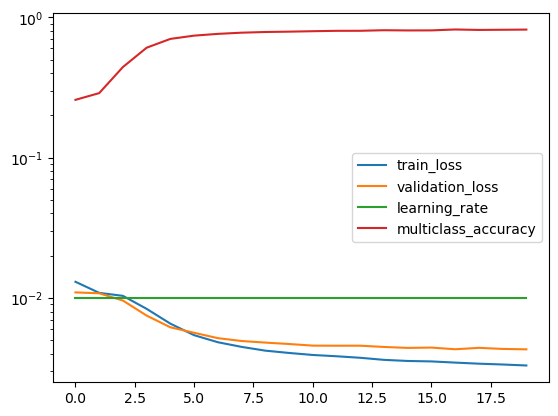

In [4]:
#example using on GPU torcheval metrics

model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4,
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [SqueezeN()],
                                           'X': []},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 100000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_redundant': 5,
                                         'n_repeated': 5,
                                         'n_clusters_per_class': 5,
                                         'flip_y': 0.05,
                                         'class_sep': 0.05,
                                         'n_classes': 4}}}
                                     
metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'metric_name': 'multiclass_accuracy', #torcheval
                 'metric_param': {'num_classes': 4}}

opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 1}

learn = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, 
              sample_param=sample_param, opt_param=opt_param, 
              sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param,
              adapt=(300,256,.2), batch_size=128, epochs=20, 
              save_model='demo_model')


In [ ]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)

model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 10000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}
                                     
learn = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, 
              batch_size=128, epochs=2, load_model='demo_model.pth')


In [ ]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnet18',
               'in_channels': 3,
               'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': True,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}},
           'test_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': False,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}}}

metrics_param = {'report_interval': 30, 
                 'metric_name': 'roc_auc_score', 
                 'metric_param': {'average': 'macro',
                                  'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 1,
               'cooldown': 1}

learn = Learn([TVDS,TVDS], 
              tv_model, 
              Selector, 
              Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
              model_param=model_param, ds_param=ds_param, sample_param=sample_param, 
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=16, epochs=10)

In [ ]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnext50_32x4d',
               'in_channels': 3,
               'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': True,
                                       'transform': transforms.Compose([
                                                    transforms.RandomRotation(10),
                                                    transforms.Resize(256),
                                                    transforms.ToTensor()]),
                                       'target_transform': None}},
           'test_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': False,
                                       'transform': transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.ToTensor()]),
                                       'target_transform': None}}}

metrics_param = {'report_interval': 60, 
                 'metric_name': 'roc_auc_score', 
                 'metric_param': {'average': 'macro',
                                  'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_param=model_param, ds_param=ds_param, 
          sample_param=sample_param, opt_param=opt_param, 
          sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=16, epochs=10)